In [2]:
pip install torch_geometric

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [5]:
#### run this if using collab

# from google.colab import drive

# drive.mount('/content/drive')

In [6]:
# "/content/drive/MyDrive/Colab Notebooks/GNN/try_networkx_data_training_recruitment.csv"
df = pd.read_csv("try_networkx_data_testing_recruitment.csv")


### Data Preprocessing and Graph Construction

In [7]:
#### constants ######

array_of_skills =  [f'Skill {i}' for i in range(1, 11)]
data_testing_10 = df.head(10)

In [8]:

#create nodes for persons, skills and job
# purpose => extract unique lists of persons, skills, and jobs from dataset
persons = df['ID'].tolist()
skills = list(set(df[array_of_skills].values.flatten()) - {"-"})

# map nodes
# purpose => create dictionaries to map each person, skill and job to unque index
person_idx = {p: i for i, p in enumerate(persons)}
skill_idx = {s: i+len(persons) for i, s in enumerate(skills)}

edges = []

# person to skill edges
for i, row in df.iterrows():
    for skill in array_of_skills:
        if row[skill] != "-":
            # connect each person to their listed skills
            edges.append((person_idx[row["ID"]], skill_idx[row[skill]]))

# convert edges to Pytorch tensors
# purpose convert the list of edges to a PyTorch tensor suitable for PyTorch Geometric
# converts the list of edges to a tensor and transposes it to match the required shape
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()


#create node features (for simplicity, using one-hot encoding for persons and jobs)
num_persons = len(persons)
num_skills = len(skills)
num_nodes = num_persons + num_skills

# creates an identity matrix where each row corresponds to a one-hot encoded vector for a node
x = torch.eye(num_nodes)

# Create PyTorch Geometric Data Object
# purpose => combine the node features and edge indices into a single daa structure used by Pytorch Geometric
data = Data(x=x, edge_index=edge_index)

### Define and Train a GNN Model

In [9]:
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()

        # GCN layer that reduces the feature size to 16
        self.conv1 = GCNConv(num_nodes, 16)

        # second GCN layer that reduces the feature size to the number oof job categories
        self.conv2 = GCNConv(16, num_skills)

#  define forward pass of the network
    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # applies the first GCN layer, followed by ReLU activation
        x = self.conv1(x, edge_index)
        x = F.relu(x)

        # applies the second GCN layer
        x = self.conv2(x, edge_index)
        return x

model = GNN()

# adam optimizer to update the model parameters with a leaerning rate of 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
training_losses = []

def train(data, epochs=100):
    model.train()
    target = torch.zeros(num_persons, num_skills)
    for i, row in df.iterrows():
        for skill in array_of_skills:
            if row[skill] != "-":
                target[person_idx[row["ID"]], skill_idx[row[skill]] - len(persons)] = 1


    for epoch in range(epochs):
        # clear the gradients from the previous step
        optimizer.zero_grad()

        # get the model's output for the person nodes
        out = model(data)[:num_persons]

        # calculates the cross-entropy loss between the model's output and the
        # target job indexs
        loss = F.cross_entropy(out, target)
        loss.backward()
        training_losses.append(loss.item())
        #updates the model parameters based on the gradients
        optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

train(data)


Epoch 1, Loss: 12.203583717346191
Epoch 2, Loss: 12.162903785705566
Epoch 3, Loss: 12.126154899597168
Epoch 4, Loss: 12.092314720153809
Epoch 5, Loss: 12.060097694396973
Epoch 6, Loss: 12.028464317321777
Epoch 7, Loss: 11.996434211730957
Epoch 8, Loss: 11.963900566101074
Epoch 9, Loss: 11.930654525756836
Epoch 10, Loss: 11.896263122558594
Epoch 11, Loss: 11.860359191894531
Epoch 12, Loss: 11.823151588439941
Epoch 13, Loss: 11.78439712524414
Epoch 14, Loss: 11.743927955627441
Epoch 15, Loss: 11.702213287353516
Epoch 16, Loss: 11.658988952636719
Epoch 17, Loss: 11.614274024963379
Epoch 18, Loss: 11.568497657775879
Epoch 19, Loss: 11.521526336669922
Epoch 20, Loss: 11.473381042480469
Epoch 21, Loss: 11.424120903015137
Epoch 22, Loss: 11.373337745666504
Epoch 23, Loss: 11.32160758972168
Epoch 24, Loss: 11.269133567810059
Epoch 25, Loss: 11.215814590454102
Epoch 26, Loss: 11.161933898925781
Epoch 27, Loss: 11.107316970825195
Epoch 28, Loss: 11.052148818969727
Epoch 29, Loss: 10.996310234069

In [10]:
def render_loss_plot():
    plt.figure(figsize=(8, 6))
    plt.plot(range(len(training_losses)), training_losses, marker='o', label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

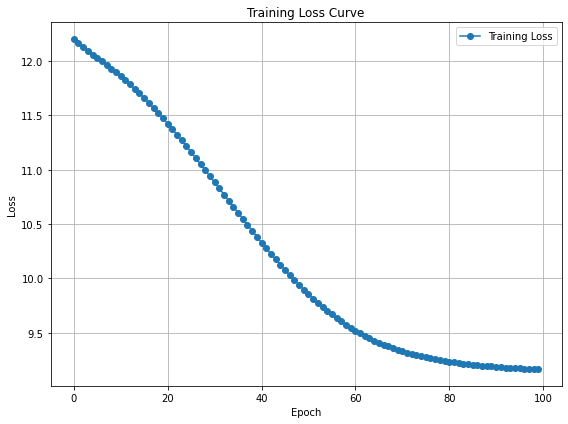

In [11]:
render_loss_plot()

### Making Predictions

In [13]:
def predict(person_id):
    # set model to evaluation mode
    model.eval()

    with torch.no_grad():
        #passes the data through the model to get the raw output (logits) for all nodes
        out = model(data)

        # print(person_idx)
        # retrieves the index of the specified person from the person_indx dictionary
        person_index = person_idx[person_id]
        #applies the softmax function to the raw logits to convert them into probabilities.
        #the softmax function outputs a probabilit distribution over the classes for each node
        #  probs = F.softmax(out, dim=1)
        #  return probs[person_index]
        probs = F.sigmoid(out[person_index])
        skill_probs = {skill: probs[skill_idx[skill] - len(persons)].item() for skill in skills}
        return skill_probs


def predict_top_k(person_id, k=3):
    model.eval()
    with torch.no_grad():
       # only interested in person nodes output
        out = model(data)[:num_persons]
        person_index = person_idx[person_id]
         # Apply sigmoid to get probabilities
        probs = F.sigmoid(out[person_index])

        # Ensure that k is not greater than the number of jobs
        topk_probs, topk_indices = torch.topk(probs, k)
        topk_skills = [skills[i] for i in topk_indices]
        skill_probs = {skill: prob.item() for skill, prob in zip(topk_skills, topk_probs)}
        return skill_probs



probs = predict('C2')
print(f"Predicted skill probabilities for person 'E2':", probs)

# Create a DataFrame to store predictions
df_prediction = pd.DataFrame(columns=['ID', 'Actual Skill', 'Predicted Skill', 'Probability'])
df_prediction.index.name = 'No'

for person in persons:
    probs = predict(person)
    actual_skills = df[df['ID'] == person][array_of_skills].values.flatten()
    actual_skills = [skill for skill in actual_skills if skill != "-"]
    for skill, prob in probs.items():
        if prob > 0.7:
            new_row = {'ID': person, 'Actual Skill': ', '.join(actual_skills), 'Predicted Skill': skill, 'Probability': prob}
            df_prediction = pd.concat([df_prediction, pd.DataFrame(new_row, index=[0])], ignore_index=True)

print(df_prediction)

Predicted skill probabilities for person 'E2': {'Data Visualization': 0.20697125792503357, 'Communication': 0.9408375024795532, 'Adaptability': 0.1948932558298111, 'Critical Thinking': 0.14660866558551788, 'Analytical Thinking': 0.09857450425624847, 'Leadership': 0.9404770731925964, 'Time Management': 0.9406725168228149, 'Problem Solving': 0.120633564889431, 'Team Work': 0.9410168528556824, 'Creativity': 0.08679346740245819}
       ID                                       Actual Skill  \
0      C1  Critical Thinking, Data Visualization, Creativity   
1      C1  Critical Thinking, Data Visualization, Creativity   
2      C1  Critical Thinking, Data Visualization, Creativity   
3      C2  Communication, Time Management, Team Work, Lea...   
4      C2  Communication, Time Management, Team Work, Lea...   
..    ...                                                ...   
517  C100  Critical Thinking, Team Work, Adaptability, Cr...   
518  C100  Critical Thinking, Team Work, Adaptability, Cr..

In [17]:
df_prediction

,ID,Actual Skill,Predicted Skill,Probability
0,E1,"Critical Thinking, Data Visualization, Creativity",Creativity,0.978461
1,E1,"Critical Thinking, Data Visualization, Creativity",Critical Thinking,0.978496
2,E1,"Critical Thinking, Data Visualization, Creativity",Data Visualization,0.978683
3,E2,"Communication, Time Management, Team Work, Lea...",Team Work,0.969404
4,E2,"Communication, Time Management, Team Work, Lea...",Communication,0.970002
...,...,...,...,...
2628,E509,"Communication, Time Management, Team Work, Cre...",Creativity,0.875924
2629,E509,"Communication, Time Management, Team Work, Cre...",Team Work,0.876744
2630,E509,"Communication, Time Management, Team Work, Cre...",Communication,0.875012
2631,E509,"Communication, Time Management, Team Work, Cre...",Leadership,0.873394


In [14]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score

# Creating confusion matrices for each skill
all_actual_skills = df_prediction['Actual Skill'].str.get_dummies(', ')
all_predicted_skills = df_prediction['Predicted Skill'].str.get_dummies(', ')

confusion_matrices = {}
roc_aucs = {}
accuracies = []
precisions = []
recalls = []
f1_scores = []

for skill in skills:
    if skill in all_actual_skills.columns and skill in all_predicted_skills.columns:
        y_true = all_actual_skills[skill]
        y_pred = all_predicted_skills[skill]
        confusion_matrices[skill] = confusion_matrix(y_true, y_pred)
         # ROC AUC
        roc_aucs[skill] = roc_auc_score(y_true, y_pred)

        # Accuracy, Precision, Recall, F1
        accuracies.append(accuracy_score(y_true, y_pred))
        precisions.append(precision_score(y_true, y_pred))
        recalls.append(recall_score(y_true, y_pred))
        f1_scores.append(f1_score(y_true, y_pred))

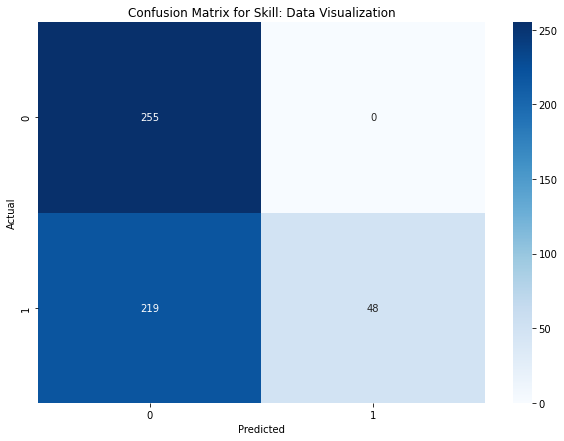

In [15]:
import seaborn as sn
# Visualizing one of the confusion matrices
skill_to_plot = skills[0]
confusion_matrix_to_plot = confusion_matrices[skill_to_plot]

fig = plt.figure(figsize=(10, 7))
sn.heatmap(confusion_matrix_to_plot, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix for Skill: {skill_to_plot}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [16]:
import matplotlib.pyplot as plt

# Calculate average metrics
average_accuracy = sum(accuracies) / len(accuracies)
average_precision = sum(precisions) / len(precisions)
average_recall = sum(recalls) / len(recalls)
average_f1_score = sum(f1_scores) / len(f1_scores)
average_roc_auc = sum(roc_aucs.values()) / len(roc_aucs)

# Print the average metrics
print(f'Average Accuracy: {average_accuracy:.2f}')
print(f'Average Precision: {average_precision:.2f}')
print(f'Average Recall: {average_recall:.2f}')
print(f'Average F1 Score: {average_f1_score:.2f}')
print(f'Average ROC AUC: {average_roc_auc:.2f}')

# # Create a bar chart
# metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
# values = [average_accuracy, average_precision, average_recall, average_f1_score, average_roc_auc]

# plt.figure(figsize=(10, 6))
# plt.bar(metrics, values, color=['blue', 'orange', 'green', 'red', 'purple'])
# plt.ylim(0, 1)
# plt.title('Average Metrics for Multi-Label Classification')
# plt.ylabel('Scores')
# plt.xlabel('Metrics')
# for i, v in enumerate(values):
#     plt.text(i, v + 0.02, f'{v:.2f}', ha='center', fontweight='bold')
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.show()


Average Accuracy: 0.53
Average Precision: 1.00
Average Recall: 0.17
Average F1 Score: 0.30
Average ROC AUC: 0.59


In [17]:
print('confusion_matrix_to_plot', confusion_matrix_to_plot)

confusion_matrix_to_plot [[255   0]
 [219  48]]


### Precision, Recall, Acuracies and F1 Scores

In [18]:
class_labels = confusion_matrix_to_plot.flatten()[: len(confusion_matrix_to_plot)]

def render_plot():
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
    values = [average_accuracy, average_precision, average_recall, average_f1_score, average_roc_auc]

    plt.figure(figsize=(10, 6))
    plt.plot(metrics, values, marker='s', label='Average Metrics')
    plt.ylim(0, 1)
    plt.title('Average Metrics for Multi-Label Classification')
    plt.ylabel('Scores')
    plt.xlabel('Metrics')
    plt.grid(True)
    for i, v in enumerate(values):
        plt.text(i, v + 0.02, f'{v:.2f}', ha='center', fontweight='bold')
    plt.tight_layout()
    plt.show()


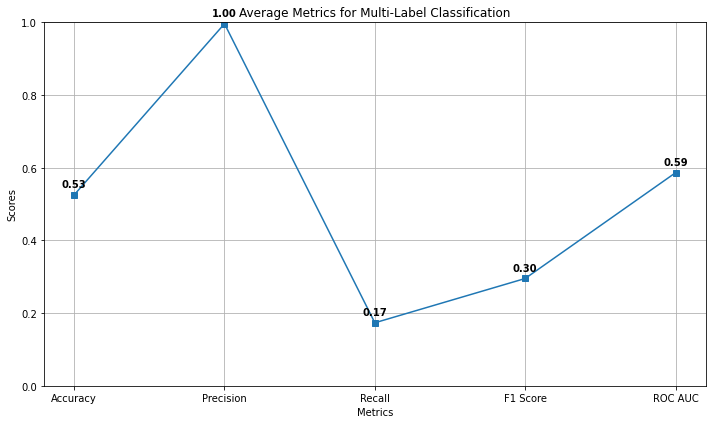

In [19]:
render_plot()

### Visualize Graph

In [ ]:
# print('persons', persons)
# print('edges', edges)

In [20]:
import networkx as nx
import matplotlib.pyplot as plt

# Define the visualize_graph function
def visualize_graph(person_id, new_edges, threshold=0.7):
    probs = predict(person_id)
    G = nx.Graph()

    # Add nodes for persons and skills
    G.add_nodes_from(persons, bipartite=0)
    G.add_nodes_from(skills, bipartite=1)

    # Add edges based on predefined relationships
    for edge in new_edges:
        if edge[0] < len(persons):
            if edge[1] >= len(persons):
                G.add_edge(list(person_idx.keys())[edge[0]], list(skill_idx.keys())[edge[1] - len(persons)])

    ##### STYLING #####
    custom_gray = '#f4f4f4'
    custom_blue = '#e6fbff'

    # Add predicted edges based on probabilities
    for job_name, prob in probs.items():
        if prob >= threshold:
            G.add_edge(person_id, job_name, color='red')
        elif prob >= 0.5 and prob < threshold:
            G.add_edge(person_id, job_name, color='blue', style='dashed', alpha=0.7)
        else:
            G.add_edge(person_id, job_name, color=custom_gray, alpha=0.7)

    # Get edge attributes for coloring and styling
    nx_edges = G.edges(data=True)
    colors = [dt['color'] if 'color' in dt else custom_blue for _, _, dt in nx_edges]
    styles = [dt['style'] if 'style' in dt else 'solid' for _, _, dt in nx_edges]

    # Create a multipartite layout
    pos = nx.multipartite_layout(G, subset_key="bipartite", align="vertical")

    # Define positions for nodes
    # Distance between layers
    x_offset = 5
    # Space between nodes within each layer
    y_spacing = 10

    # Adjust the positions to apply custom spacing
    for node, (x, y) in pos.items():
        if G.nodes[node]['bipartite'] == 0:
            pos[node] = (x, y * y_spacing)
        elif G.nodes[node]['bipartite'] == 1:
            pos[node] = (x + x_offset, y * y_spacing)

    # Define node colors based on the bipartite attribute
    node_colors = []
    for node in G.nodes():
        if G.nodes[node]['bipartite'] == 0:
            node_colors.append('lightblue')
        else:
            node_colors.append('lightgreen')

    # Draw the graph
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, edge_color=colors, style=styles, node_size=5000, node_color=node_colors, font_size=10)
    plt.show()



# Example usage



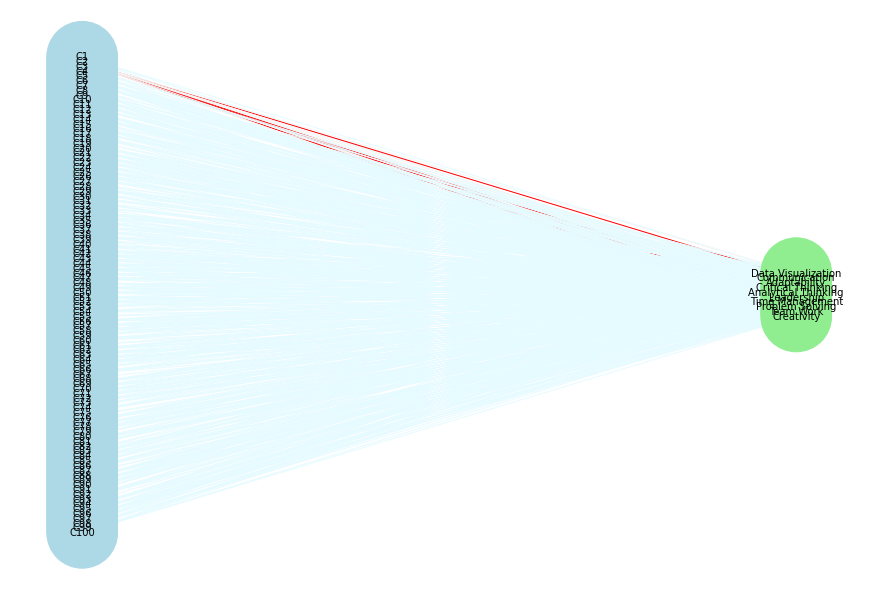

In [21]:
# Create edges based on data
new_edges = []
# Person to Skill edges
for i, row in df.iterrows():
    for skill in array_of_skills:
        if row[skill] != "-":
            new_edges.append((person_idx[row["ID"]], skill_idx[row[skill]]))

visualize_graph('C2', new_edges, threshold=0.7)